# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by Simone Candeloro

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [2]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [3]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 9308 / 11441 MB available


In [4]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel(float* c, float* a, float* b, int cols) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    //Pseudocode
    //c[j][i] = a[j][i] + b[j][i]
    unsigned int k = j*cols + i;
    
    c[k] = a[k] + b[k];    
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addMatrixKernel");

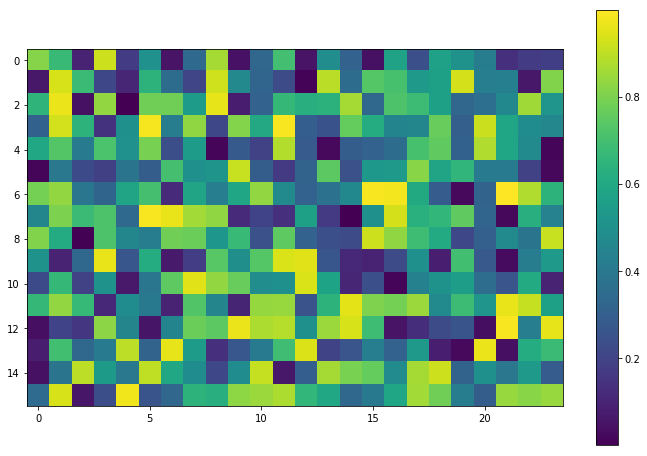

In [5]:
#Size of our test
test_size = (16, 24)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random(test_size).astype(np.float32)
c = np.empty_like(a)

fig = plt.figure(figsize=(12,8))
plt.imshow(a)
plt.colorbar()
plt.show()

In [6]:
print(a.shape)

(16, 24)


In [7]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [8]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [19]:
# a.shape = [rows, columns] => [y index, x index]
domain_size = (a.shape[1], a.shape[0]) # Now domain size is [x, y]
block_size = (8, 4, 1) # These need to be x, y, z!
grid_size = (domain_size[0] // block_size[0], domain_size[1] // block_size[1], 1)

print("Domain_size is " + str(domain_size))
print("Block_size is " + str(block_size))
print("Grid_size is " + str(grid_size))

Domain_size is (24, 16)
Block_size is (8, 4, 1)
Grid_size is (3, 4, 1)


In [22]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[1.7460958 , 1.6144724 , 0.8576971 , 1.7668974 , 0.77150077,
        1.4159063 , 0.42146766, 0.8881496 , 1.4079072 , 0.99683285,
        0.76192   , 0.7109317 , 0.52480376, 1.4797752 , 0.6978142 ,
        0.40132838, 0.62402636, 0.36880797, 1.560997  , 0.5528035 ,
        1.0593493 , 0.58976334, 0.98658293, 1.0664569 ],
       [1.0160726 , 1.1655188 , 1.2343342 , 1.0834776 , 0.8245543 ,
        0.7593875 , 0.87686336, 1.1596818 , 0.96647465, 0.63298655,
        0.67284125, 0.6038208 , 0.44597203, 1.6013865 , 1.230902  ,
        0.77995104, 1.1525937 , 0.9186778 , 1.3763828 , 1.6056861 ,
        0.5836307 , 1.3811679 , 0.4436378 , 1.3240609 ],
       [1.4158343 , 1.0218375 , 0.485654  , 1.4258468 , 0.6561454 ,
        1.2123048 , 1.7212734 , 1.511625  , 1.5435398 , 0.15404904,
        0.57045305, 1.1625159 , 0.88734436, 1.4053425 , 1.6890285 ,
        0.75916517, 1.4461966 , 1.5771526 , 1.0512497 , 1.1776524 ,
        0.42977417, 0.81484765, 1.1814458 , 0.6721314 ],
       [0.644

In [23]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[1.7460958  1.6144724  0.8576971  1.7668974  0.77150077 1.4159063
  0.42146766 0.8881496  1.4079072  0.99683285 0.76192    0.7109317
  0.52480376 1.4797752  0.6978142  0.40132838 0.62402636 0.36880797
  1.560997   0.5528035  1.0593493  0.58976334 0.98658293 1.0664569 ]
 [1.0160726  1.1655188  1.2343342  1.0834776  0.8245543  0.7593875
  0.87686336 1.1596818  0.96647465 0.63298655 0.67284125 0.6038208
  0.44597203 1.6013865  1.230902   0.77995104 1.1525937  0.9186778
  1.3763828  1.6056861  0.5836307  1.3811679  0.4436378  1.3240609 ]
 [1.4158343  1.0218375  0.485654   1.4258468  0.6561454  1.2123048
  1.7212734  1.511625   1.5435398  0.15404904 0.57045305 1.1625159
  0.88734436 1.4053425  1.6890285  0.75916517 1.4461966  1.5771526
  1.0512497  1.1776524  0.42977417 0.81484765 1.1814458  0.6721314 ]
 [0.6449983  1.6624213  1.1208797  0.8145385  0.6036828  1.8574686
  0.6164267  1.0443908  0.8680845  1.1616685  1.0418756  1.8263037
  0.9914553  0.59431994 1.5876617  1.4471567  1.

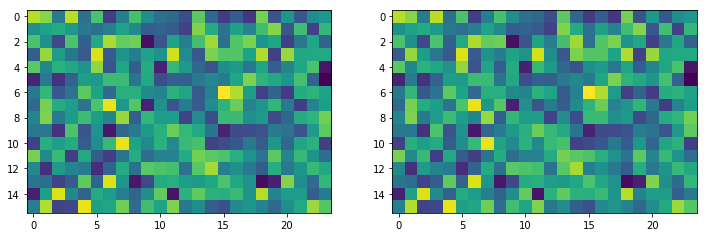

In [26]:
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)